In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation


In [4]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [210]:
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

## Map utils

In [6]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row

def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


In [7]:
def group_emisions(data):
    data_dict = data.asDict()
    recep_0 = data_dict.pop('recep_0')
    recep_1 = data_dict.pop('recep_1')
    recep_2 = data_dict.pop('recep_2')
    recep_3 = data_dict.pop('recep_3')
    
    data_dict['emissions'] = []
    for i in range(24):
        data_dict['emissions'].append([recep_0[i], recep_1[i], recep_2[i], recep_3[i]])
    return data_dict


In [8]:
points_emisions = points_recep.map(group_emisions)


In [9]:
def expand_rows_with_emissions(row):
    emissions = row.pop('emissions')
    rows = []
    for e in emissions:
        new_row = row.copy()
        new_row['recep'] = e
        rows.append(new_row)
    return rows
        
all_emissions = points_emisions.flatMap(expand_rows_with_emissions)

### Genero los atributos y etiquetas que me interesan

In [10]:
def generate_attrs(row):
    data = {
        'antenna_0': row['recep'][0],
        'antenna_1': row['recep'][1],
        'antenna_2': row['recep'][2],
        'antenna_3': row['recep'][3],
    }
    return {'data': data, 'x': row['x'], 'y': row['y'], 'point': row['Punto']}
    
all_emissions = all_emissions.map(generate_attrs)

### Saco las emisiones sin ninguna recepcion

In [11]:
all_emissions = all_emissions.filter(lambda x: sum(x['data'].values())>0)

### Normalizo coordenadas

In [12]:
all_emissions = all_emissions.map(lambda x: normalize_positions(x))

### Regresion por eje

In [13]:
regre_target = pd.DataFrame(all_emissions.map(lambda x: [x['x'], x['y']]).collect())
regre_data = pd.DataFrame(all_emissions.map(lambda x: x['data']).collect())



clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5, weights='distance'))

clf.fit(regre_data, regre_target)


MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='distance'),
           n_jobs=None)

In [211]:
BIRD_TAG_ID = 33
#START_TIME = '2018-01-20 10:00:00'
END_TIME = '2018-01-22 18:00:00'
START_TIME = '2018-01-21 10:00:00'

single_bird = birds_recep.filter(lambda x: x['tag_id'] == BIRD_TAG_ID).filter(lambda x: START_TIME <= x['timestamp'] <= END_TIME)

birds_data = pd.DataFrame(single_bird.collect()).drop(columns=[4,5])

In [212]:
predictions = clf.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(single_bird.collect())], axis=1).values

In [213]:
len(predictions)

11646

In [214]:
def update_animation(data, p):
    x = data[0]
    y = data[1]
    p.set_data(x, y)
    plt.title(data[7])
    return p
 

<IPython.core.display.Javascript object>


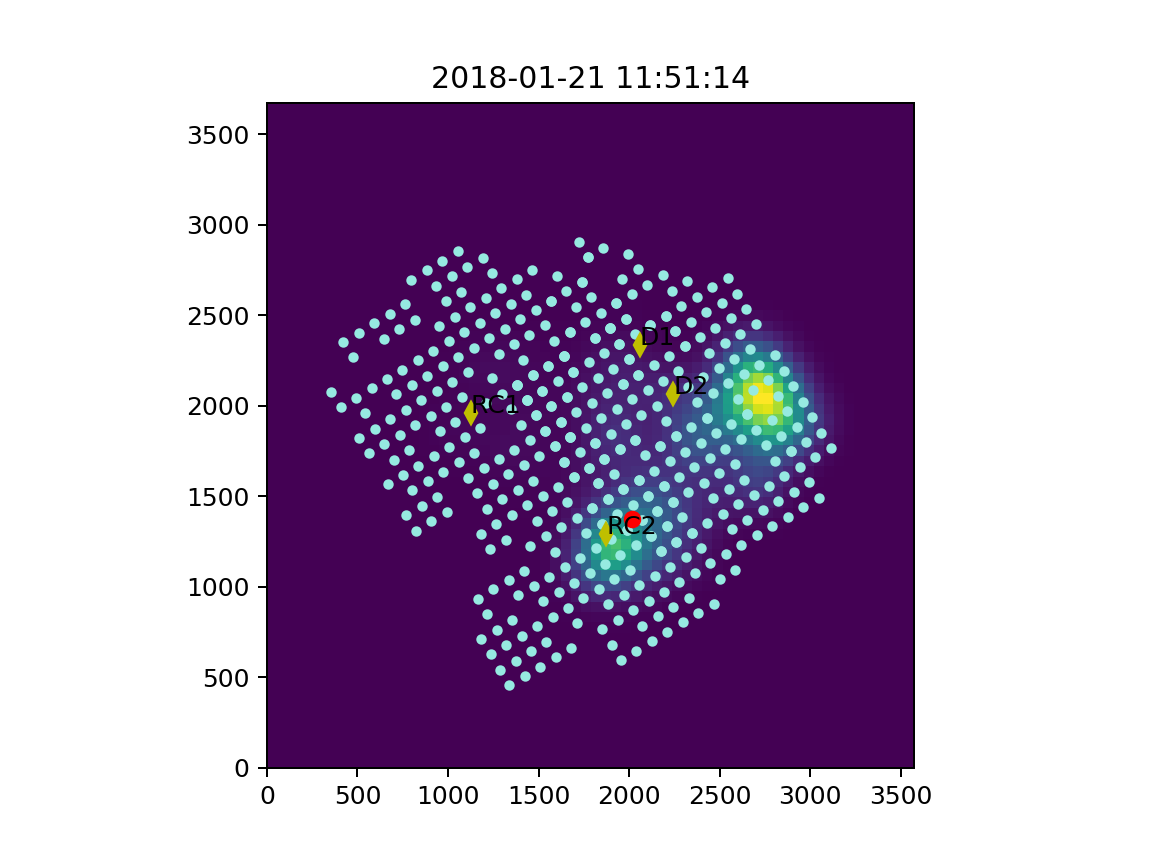

In [234]:
from scipy.ndimage.filters import gaussian_filter
DELAY = 50

fig, ax = plt.subplots()
point, = ax.plot([0], [0], 'go', color='red')
point.set_data(0, 0)
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in np.arange(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        name = nombre_antenas[antenna]
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 

range = np.array([[0,x_f-x_0],[0,y_f-y_0]])
heatmap, xedges, yedges = np.histogram2d(predictions[:,1], predictions[:,0], bins=(64,64), range=range)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
extent = [0, x_f-x_0, 0, y_f-y_0]
plt.imshow(gaussian_filter(heatmap, sigma=2, mode='nearest'), extent=extent, origin='lower', cmap=None)

ani = animation.FuncAnimation(fig, update_animation, predictions, interval=DELAY, fargs=(point,), repeat=False)
        